In [1]:
cd ..

/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing


In [6]:
import torch
import re
import numpy as np
import sklearn
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import seaborn as sns
import copy

from torch.utils.data import DataLoader
import transformer_lens
import datasets

from load import *

from analysis.load_results import (
    load_probing_experiment_results, 
    make_heuristic_probing_results_df
)

from analysis.plots import *


%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:


results_dir = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/results'
sizes = ['19m', '125m', '350m', '800m', '1.3b']
all_results = []
for s in sizes:
    results_dict = load_probing_experiment_results(results_dir, 'code_lang_max_test', 'heuristic_sparsity_sweep', f'pythia-{s}')
    rdf = make_heuristic_probing_results_df(results_dict)
    # add model size to index of rdf
    rdf.index = pd.MultiIndex.from_tuples([
        (s, *t) for t in rdf.index.values],
        names=['model_size', 'feature', 'layer', 'k']
    )
    all_results.append(rdf)
rdf = pd.concat(all_results)

In [9]:
rdf.query('k==1').sort_values('test_pr_auc', ascending=False).head(10)

test_acc test_balanced_acc test_precision  \
model_size feature layer k                                              
800m       Python  10    1  0.986803           0.98273       0.878109   
           Go      1     1  0.979162          0.975683       0.861314   
           Python  9     1  0.989812          0.980596       0.913838   
1.3b       Python  15    1   0.98796          0.979585       0.895141   
800m       Go      6     1   0.97291          0.964076       0.831239   
           Python  6     1  0.979856          0.973905       0.823113   
1.3b       Java    14    1  0.967817          0.967186       0.856608   
800m       PHP     10    1  0.986803           0.97313       0.895939   
           Java    6     1  0.969437          0.972108       0.857849   
           Go      9     1  0.978004          0.971437       0.858716   

                           test_recall test_average_precision test_roc_auc  \
model_size feature layer k                                                   
800m       Python  10    1    0.977839               0.860502     0.995591   
           Go      1     1    0.971193               0.839744     0.994865   
           Python  9     1    0.969529                0.88854     0.989364   
1.3b       Python  15    1    0.969529               0.870412     0.987288   
800m       Go      6     1    0.952675               0.797226     0.991491   
           Python  6     1    0.966759               0.798531     0.990073   
1.3b       Java    14    1    0.966245                0.83325     0.989599   
800m       PHP     10    1     0.95664               0.860795     0.986536   
           Java    6     1     0.97609               0.841274     0.988751   
           Go      9     1    0.962963               0.831079     0.991249   

                                                                     test_fpr  \
model_size feature layer k                                                      
800m       Python  10    1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           Go      1     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           Python  9     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.3b       Python  15    1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
800m       Go      6     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           Python  6     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1.3b       Java    14    1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
800m       PHP     10    1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           Java    6     1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
           Go      9     1  [0.0, 0.00026089225150013044, 0.00026089225150...   

                                                                     test_tpr  \
model_size feature layer k                                                      
800m       Python  10    1  [0.0, 0.002770083102493075, 0.0138504155124653...   
           Go      1     1  [0.0, 0.00205761316872428, 0.0205761316872428,...   
           Python  9     1  [0.0, 0.002770083102493075, 0.0193905817174515...   
1.3b       Python  15    1  [0.0, 0.002770083102493075, 0.0415512465373961...   
800m       Go      6     1  [0.0, 0.00205761316872428, 0.04320987654320987...   
           Python  6     1  [0.0, 0.002770083102493075, 0.0249307479224376...   
1.3b       Java    14    1  [0.0, 0.0014064697609001407, 0.028129395218002...   
800m       PHP     10    1  [0.0, 0.0027100271002710027, 0.054200542005420...   
           Java    6     1  [0.0, 0.0014064697609001407, 0.035161744022503...   
           Go      9     1  [0.0, 0.0, 0.00823045267489712, 0.012345679012...   

                                                         test_precision_curve  \
model_size feature layer k                                                      
800m       Python  10    1  [0.0835841630006946, 0.08360352014821677, 0.08...   
           Go      1     

In [10]:
from analysis.plots import *

In [17]:
rdf.query('model_size=="800m" and k==1').sort_values('test_pr_auc', ascending=False).head(10)['support']

model_size  feature  layer  k
800m        Python   10     1    [3855]
            Go       1      1     [884]
            Python   9      1    [1693]
            Go       6      1    [3108]
            Python   6      1    [7172]
            PHP      10     1    [5633]
            Java     6      1    [4070]
            Go       9      1    [1823]
            PHP      9      1    [7926]
            Python   1      1    [5423]
Name: support, dtype: object

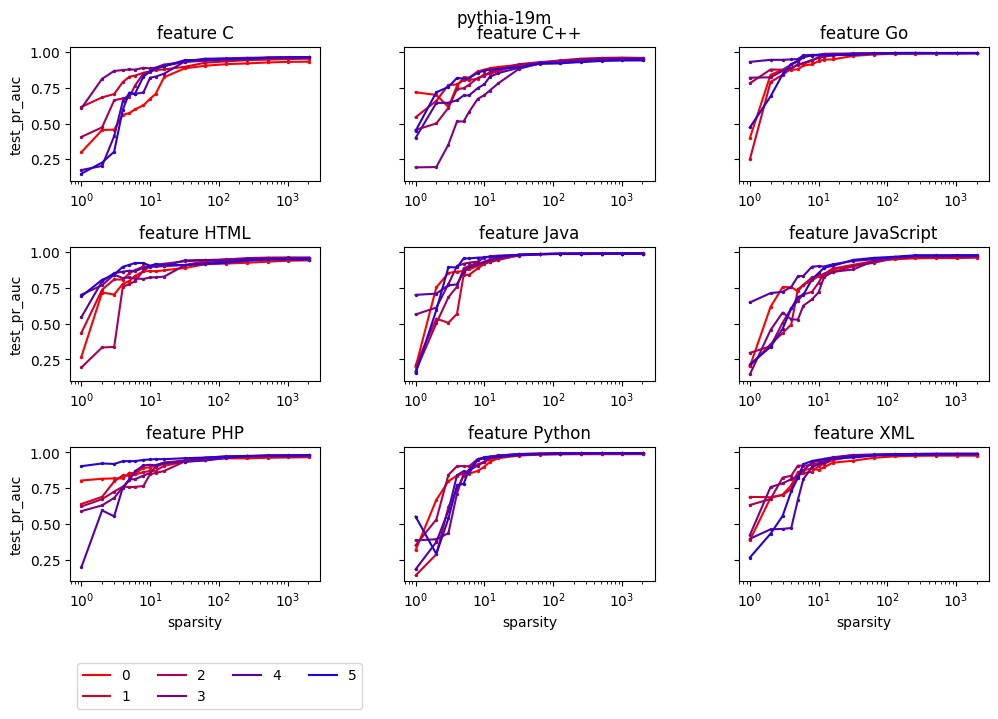

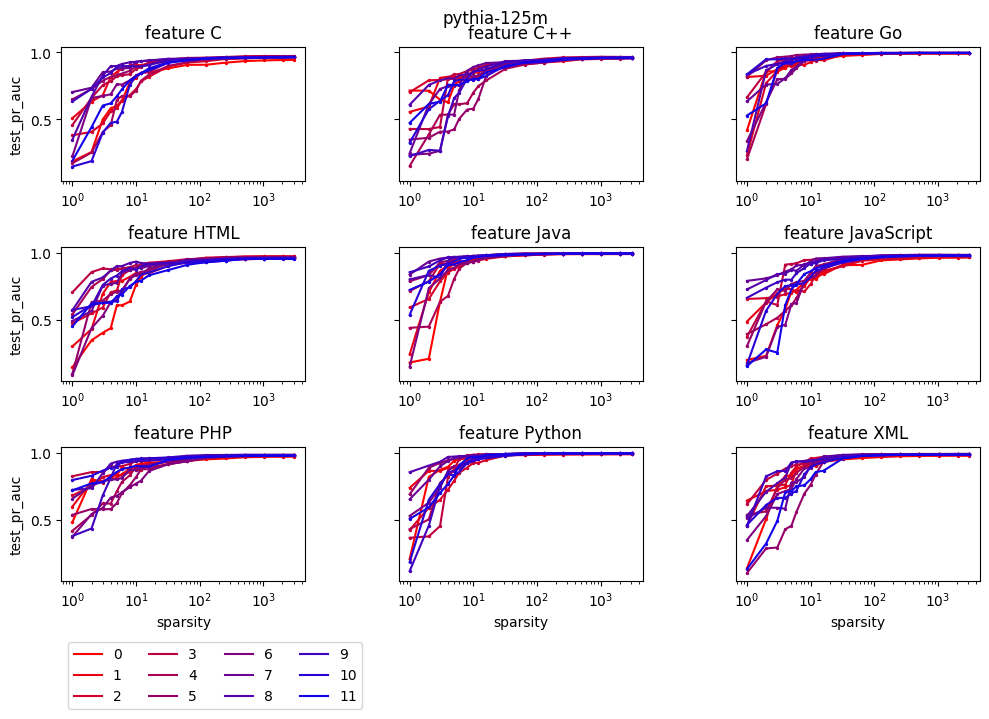

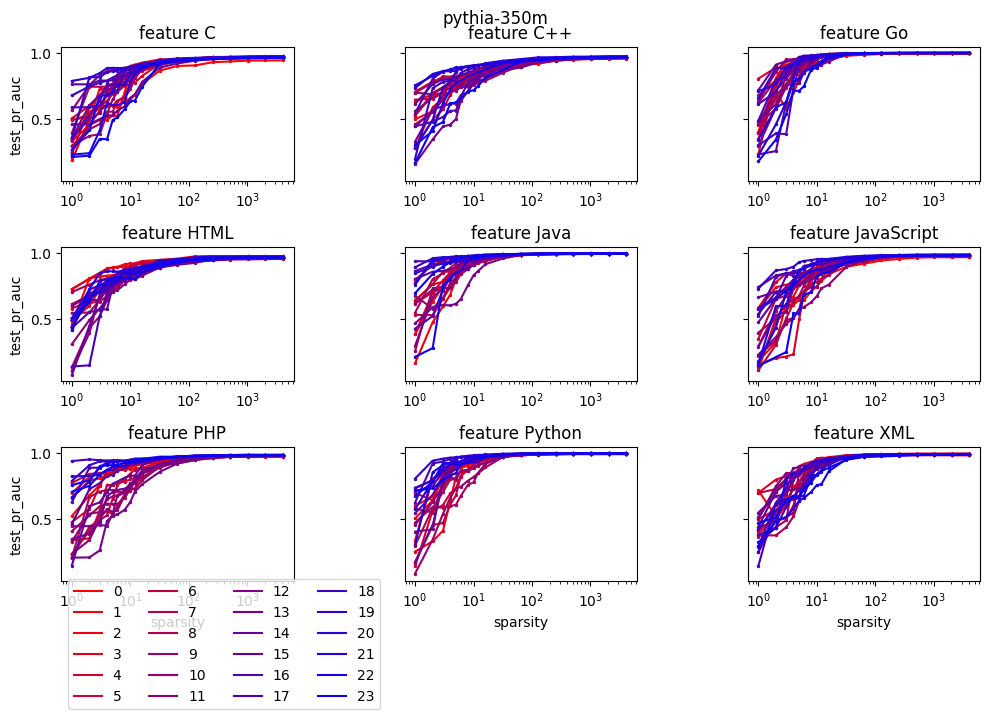

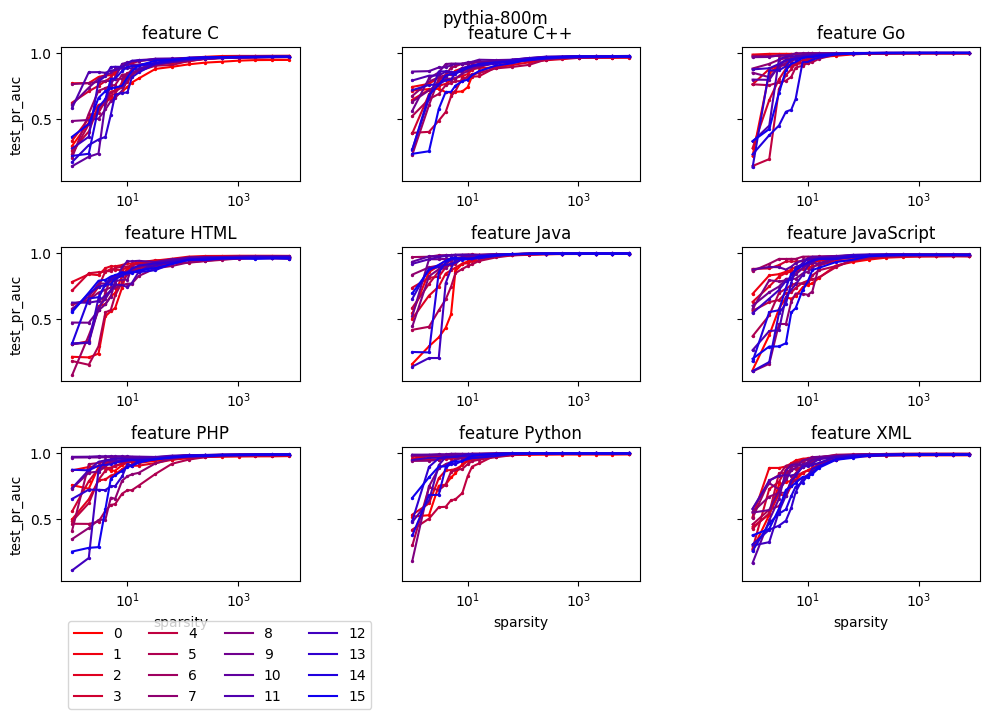

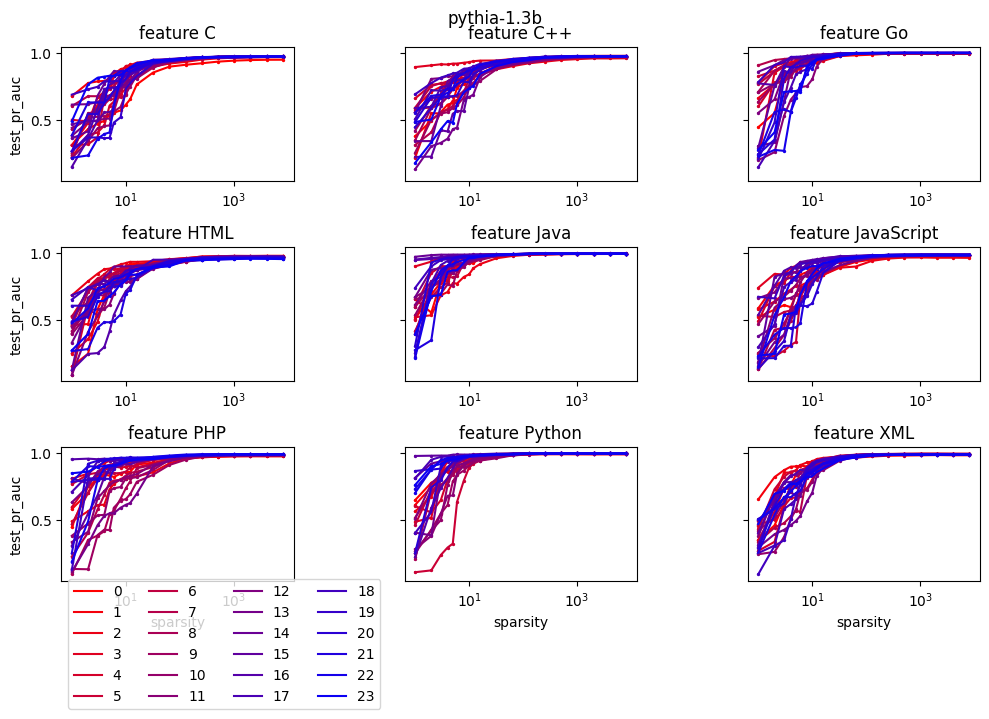

In [12]:
for s in sizes:
    plot_layer_metric_over_sparsity_per_feature(rdf.query(f'model_size=="{s}"').reset_index(level=0, drop=True), metric='test_pr_auc')
    # raise the title of the plot
    plt.suptitle(f'pythia-{s}', y=1.0)


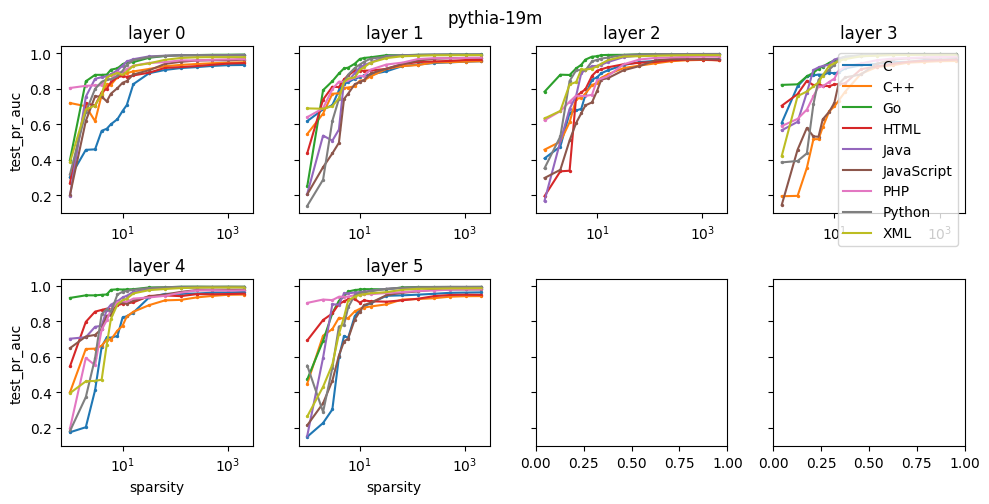

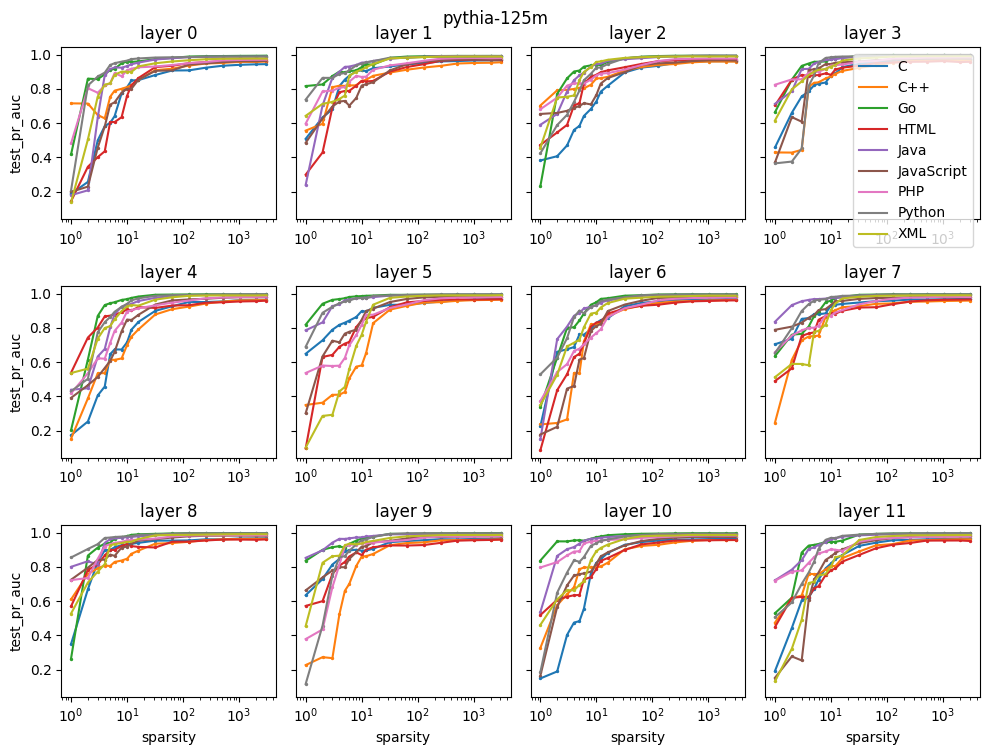

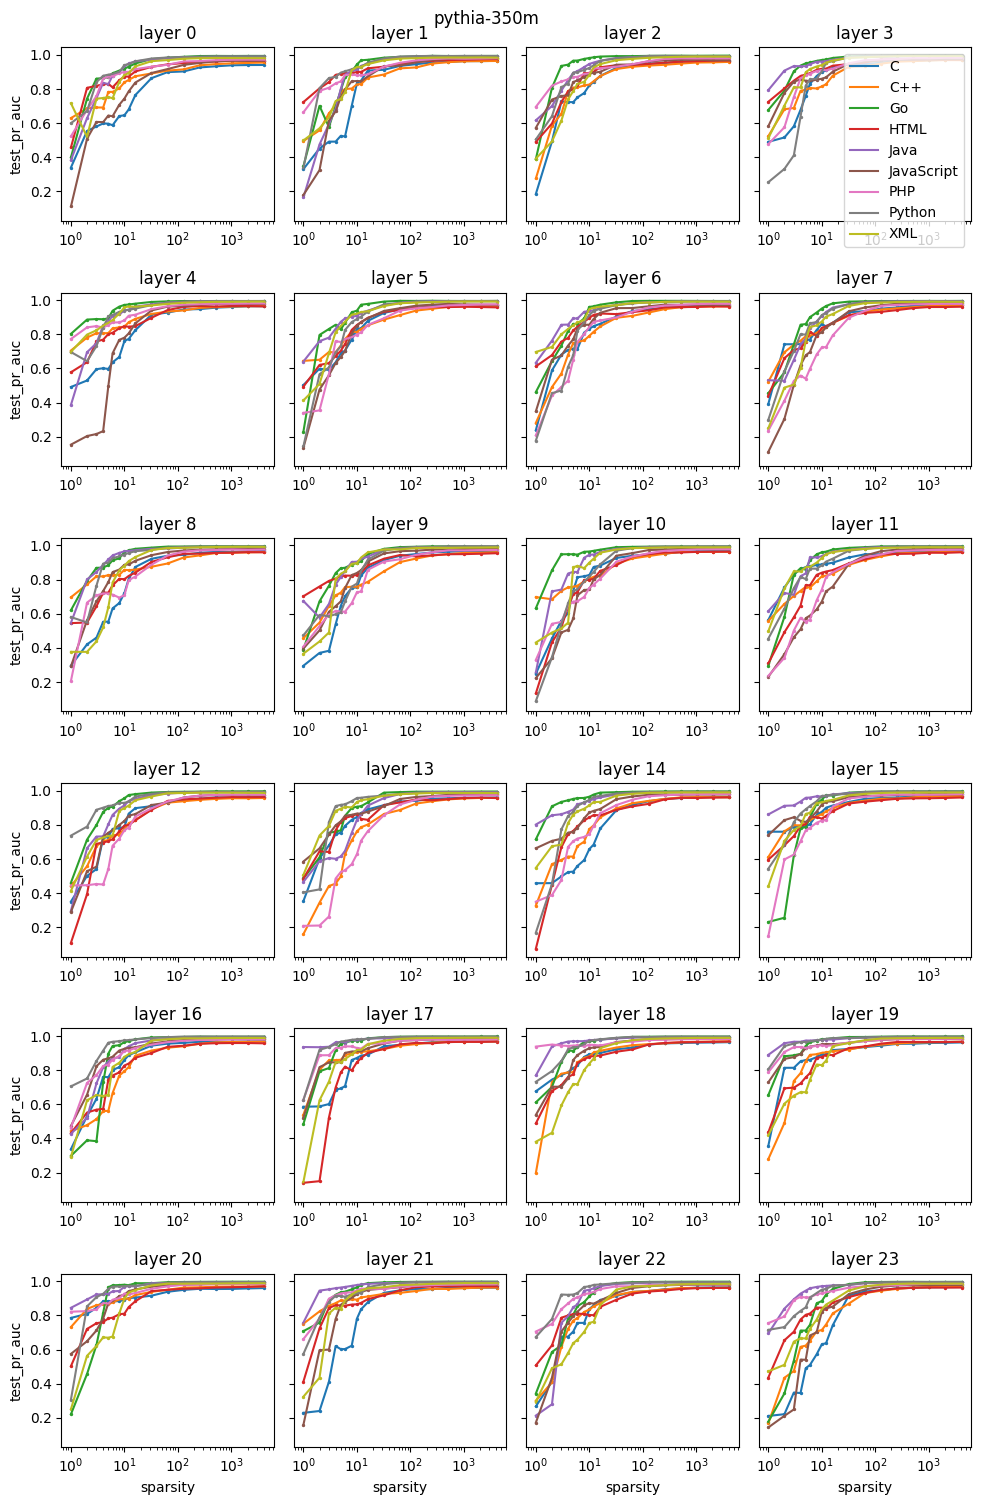

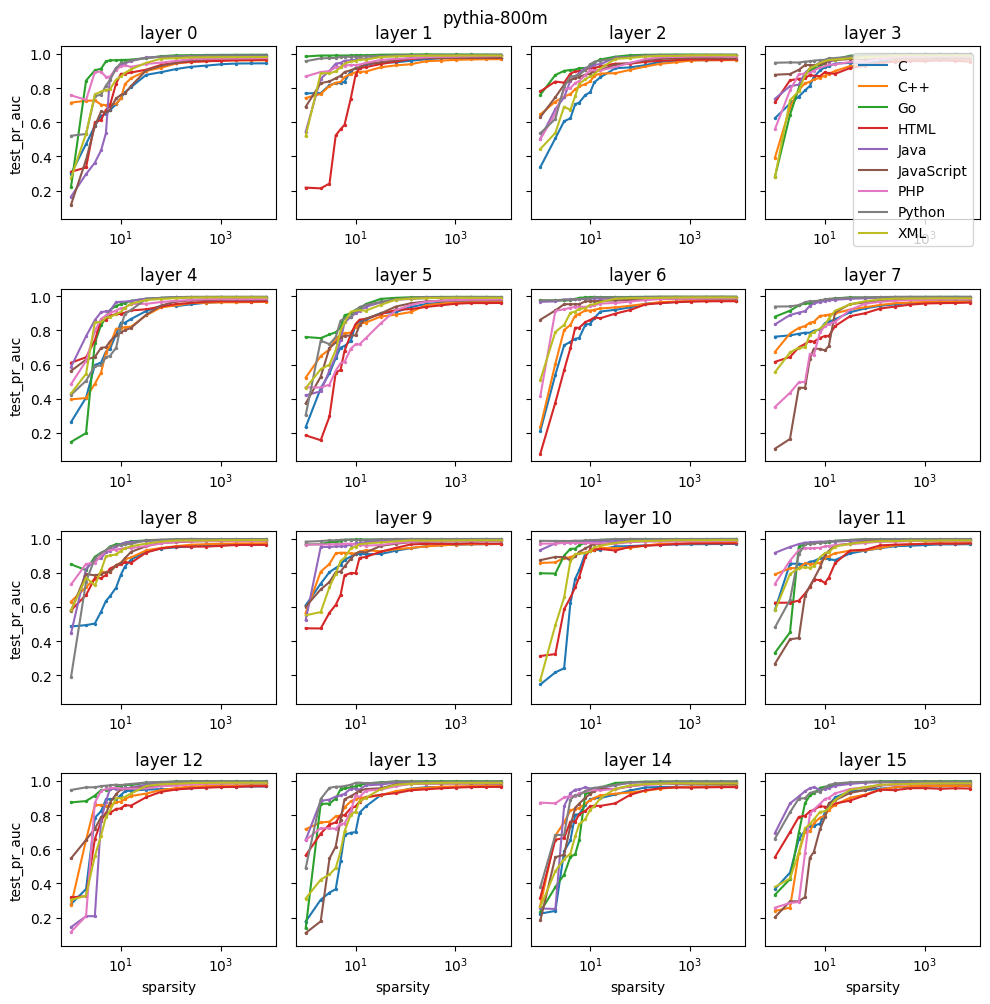

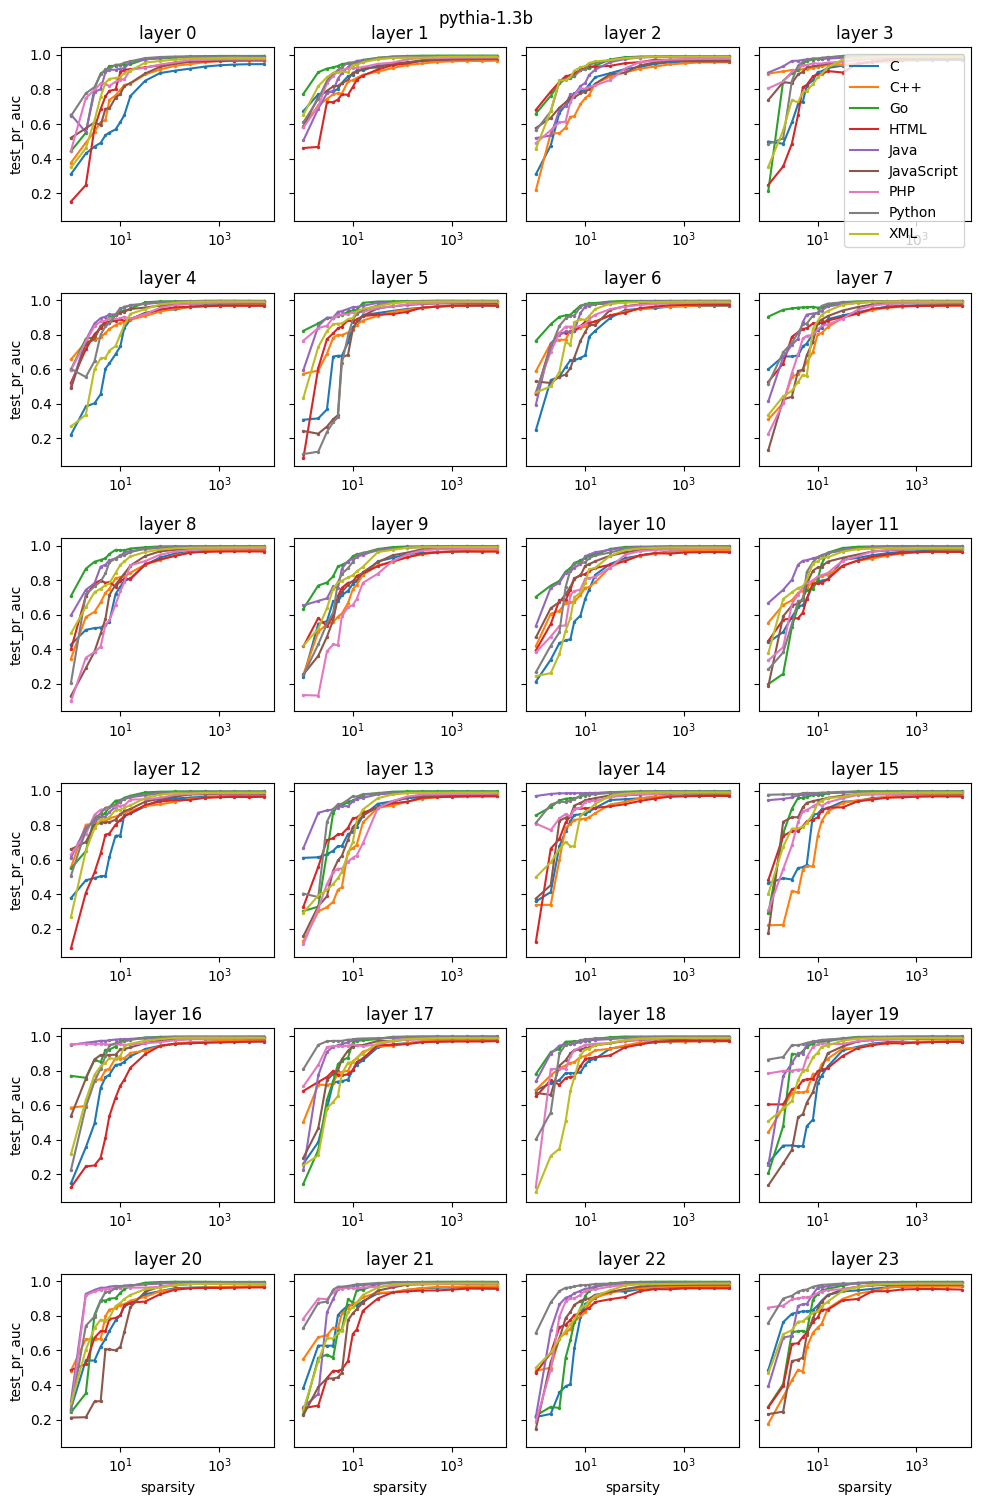

In [13]:
for s in sizes:
    plot_metric_over_sparsity_per_layer(rdf.query(f'model_size=="{s}"').reset_index(level=0, drop=True), 
    metric='test_pr_auc')
    # raise the title of the plot
    plt.suptitle(f'pythia-{s}', y=1.0)

In [77]:
one_sp.head()

test_acc test_balanced_acc test_precision  \
model_size feature    layer k                                              
800m       Go         6     1  0.964451            0.8735       0.915221   
           Python     10    1  0.965564          0.855278       0.870765   
           JavaScript 10    1  0.947349          0.857269       0.734396   
           Python     9     1   0.93502          0.828904       0.620451   
           PHP        9     1  0.952354          0.820194       0.752774   

                              test_recall test_average_precision test_roc_auc  \
model_size feature    layer k                                                   
800m       Go         6     1    0.755938               0.719473     0.866458   
           Python     10    1    0.721039               0.652745     0.833143   
           JavaScript 10    1    0.744573               0.572442     0.879756   
           Python     9     1     0.69974               0.460944     0.868821   
           PHP        9     1    0.660714               0.526429     0.806625   

                                                                        test_fpr  \
model_size feature    layer k                                                      
800m       Go         6     1  [0.0, 0.0, 0.0, 5.226298735235706e-05, 5.22629...   
           Python     10    1  [0.0, 0.0, 0.0, 5.088799552185639e-05, 5.08879...   
           JavaScript 10    1  [0.0, 0.0, 0.0, 5.151718097985678e-05, 5.15171...   
           Python     9     1  [0.0, 0.0, 0.0, 5.088799552185639e-05, 5.08879...   
           PHP        9     1  [0.0, 0.0, 0.0, 5.0689375506893756e-05, 5.0689...   

                                                                        test_tpr  \
model_size feature    layer k                                                      
800m       Go         6     1  [0.0, 0.0004095004095004095, 0.255937755937755...   
           Python     10    1  [0.0, 0.0005194805194805195, 0.235844155844155...   
           JavaScript 10    1  [0.0, 0.00046189376443418013, 0.02401847575057...   
           Python     9     1  [0.0, 0.0005194805194805195, 0.158441558441558...   
           PHP        9     1  [0.0, 0.0005411255411255411, 0.126082251082251...   

                                                            test_precision_curve  \
model_size feature    layer k                                                      
800m       Go         6     1  [0.11318131256952169, 0.11319705187039354, 0.1...   
           Python     10    1  [0.08921950315164998, 0.08922363847045191, 0.0...   
           JavaScript 10    1  [0.10034297367445309, 0.10035227588764253, 0.1...   
           Python     9     1  [0.08921950315164998, 0.08922777417261518, 0.0...   
           PHP        9     1  [0.08565072302558398, 0.08565866320571058, 0.0...   

                                                               test_recall_curve  \
model_size feature    layer k                                                      
800m       Go         6     1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
           Python     10    1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
           JavaScript 10    1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999...   
           Python     9     1  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
           PHP        9     1  [1.0, 1.0, 0.9994588744588745, 0.9994588744588...   

                              test_pr_auc elapsed_time  
model_size feature    layer k                           
800m       Go         6     1    0.819172     0.033976  
           Python     10    1    0.776324     0.044592  
           JavaScript 10    1    0.745567     0.032282  
           Python     9     1    0.740234     0.040034  
           PHP        9     1    0.702893      0.03567

In [18]:
n_layers = rdf.reset_index().groupby('model_size').layer.max().to_dict()

one_sp = rdf.query('k==1').sort_values('test_pr_auc', ascending=False).head(10)
# plot one_sp for each feature:
# x axis: normalized layer depth
# y axis: test_pr_auc
# color: model size
def plot_model_k_sparse_performance_by_feature_and_depth(rdf, k, metric):
    features = rdf.index.get_level_values('feature').unique()
    fig, axs = plt.subplots(math.ceil(len(features) / 3), 3, figsize=(15, 10), sharey=True)
    for ix, f in enumerate(features):
        ax = axs[ix // 3, ix % 3]
        for s in sizes:
            line = rdf.loc[s, f, :, k][metric]
            y = line.values
            x = line.index / n_layers[s]
            ax.plot(x, y, label=s)
        
        ax.set_title(f)
        ax.set_xlabel('Normalized layer depth')
        ax.set_ylabel(metric)
    ax.legend()
    plt.tight_layout()
    plt.suptitle(f'Best {k}-sparse performance by feature and depth', y=1.02)

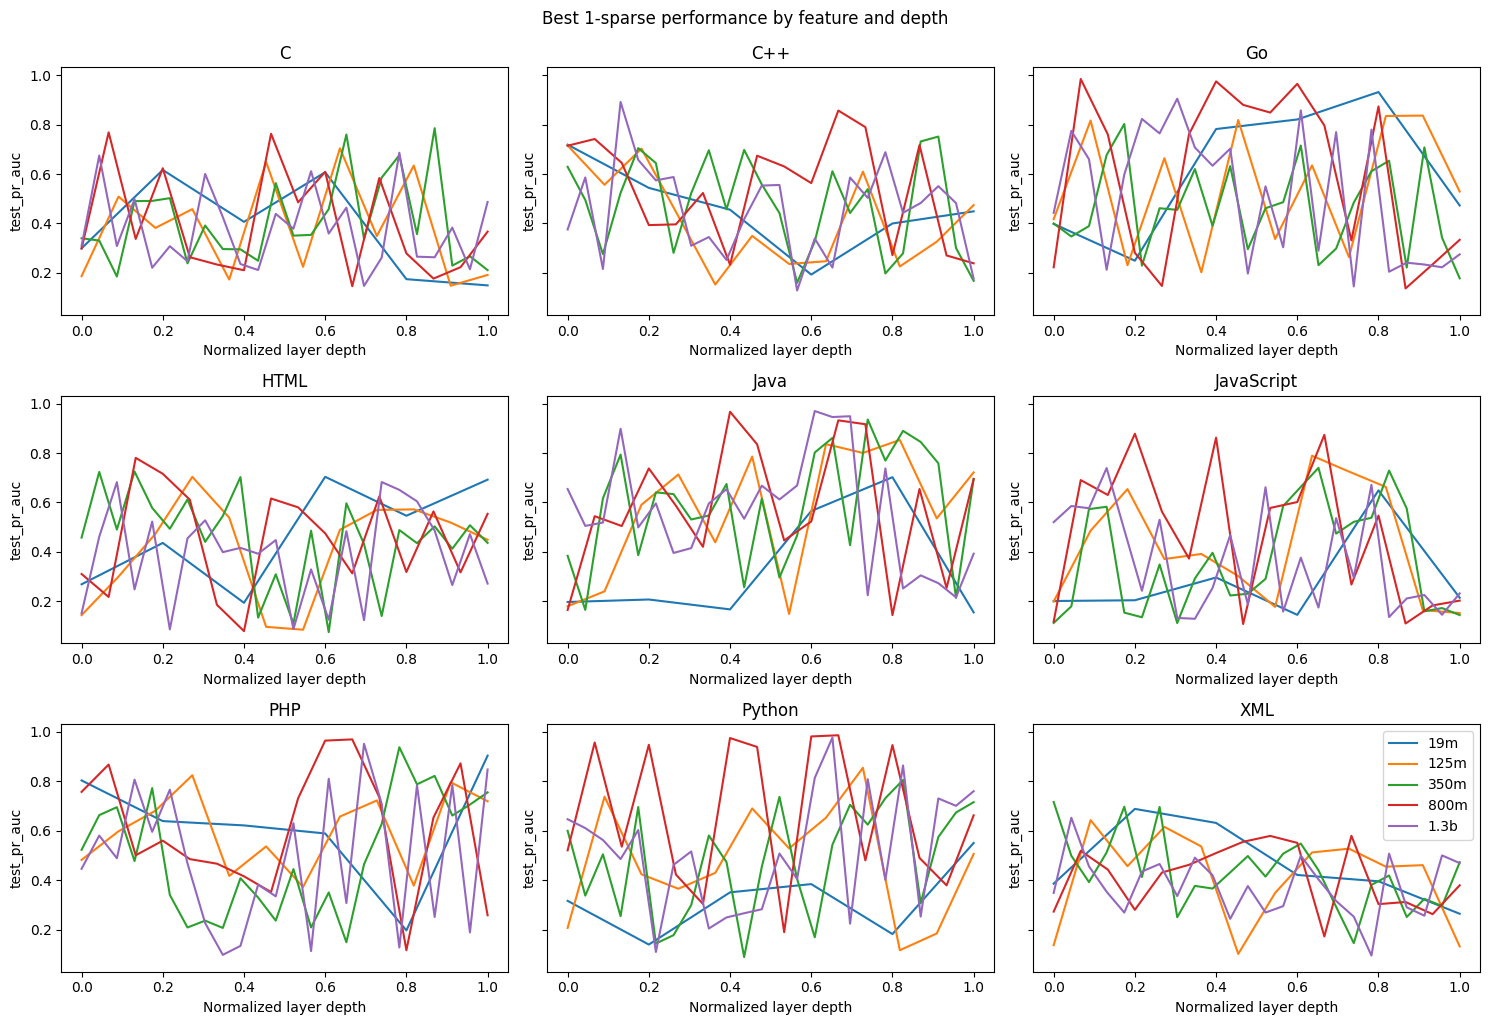

In [20]:
plot_model_k_sparse_performance_by_feature_and_depth(rdf, 1, 'test_pr_auc')

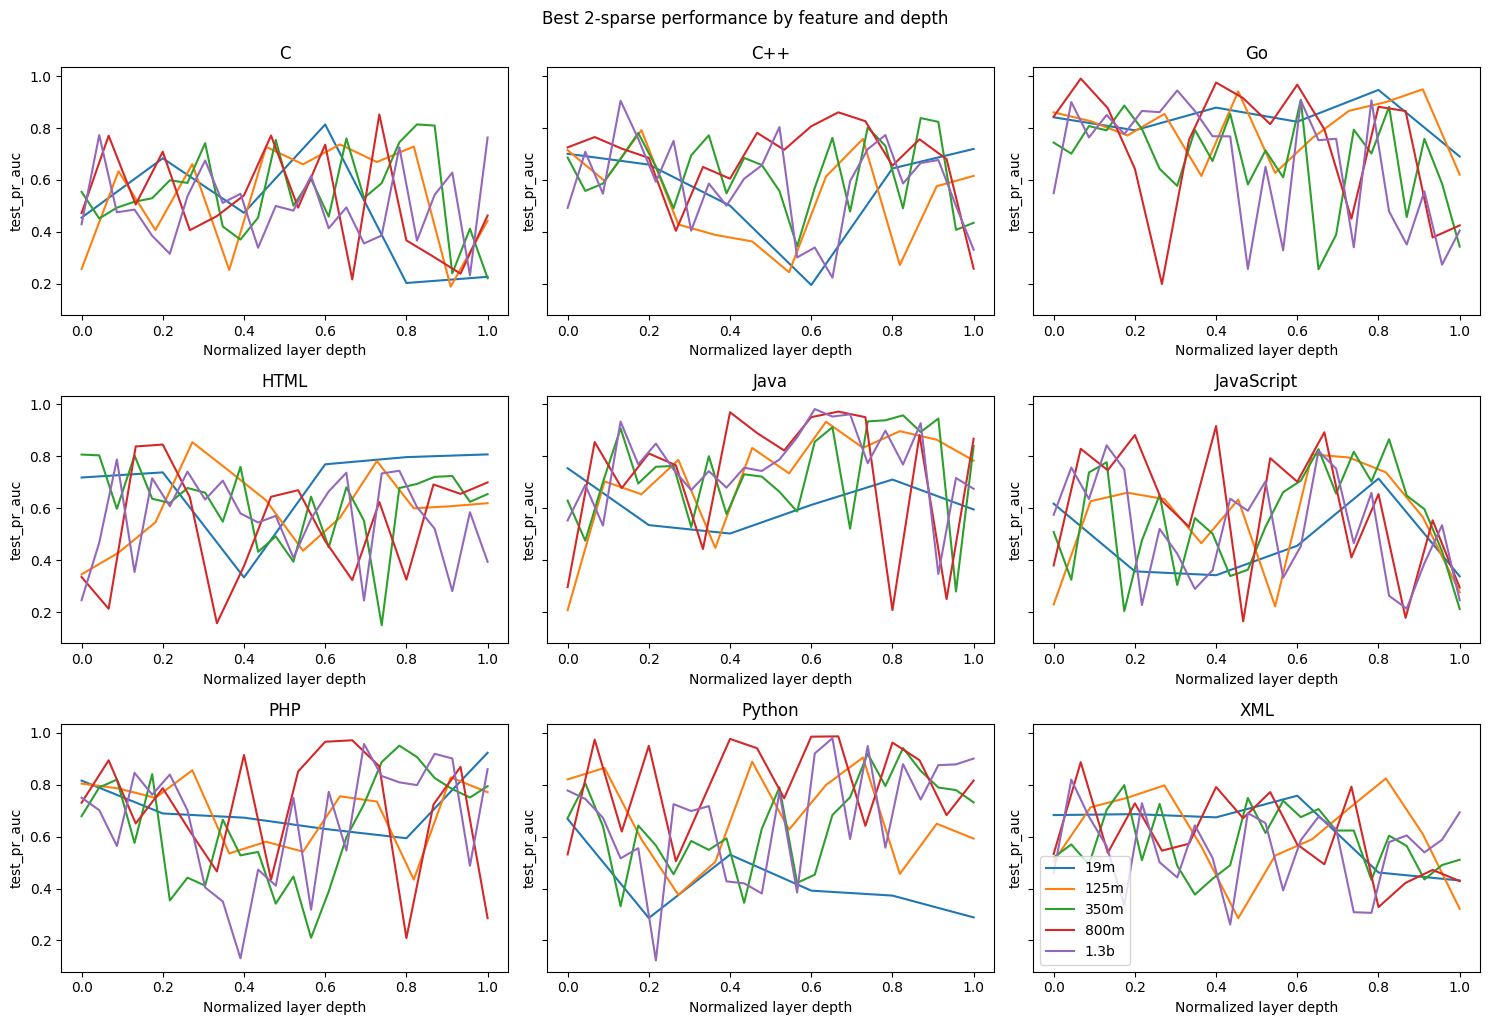

In [21]:
plot_model_k_sparse_performance_by_feature_and_depth(rdf, 2, 'test_pr_auc')

In [4]:
results_dir = '/Users/wesgurnee/Documents/mechint/sparse_probing/sparse-probing/results'
experiment_name = 'heuristic_feature_selection_test'
experiment_dir = os.path.join(results_dir, experiment_name)
results = {}
for result_file in os.listdir(experiment_dir):
    trial_info = result_file[:-2]
    experiment_name, feature, layer = trial_info.split('|')
    layer = int(layer[1:])
    if feature not in results:
        results[feature] = {}
    results[feature][layer] = pickle.load(open(os.path.join(experiment_dir, result_file), 'rb'))



In [5]:
import copy


r_datasets = results.keys()
r_layers = results[list(r_datasets)[1]].keys()

rdfs = {}
heuristic_results = []
for d in r_datasets:
    for l in r_layers:
        try:
            rdf = pd.DataFrame(results[d][l]['osp_results']).T
        except:
            continue
        rdfs[(d, l)] = rdf
        ld_result_copy = copy.deepcopy(results[d][l])
        del ld_result_copy['osp_results']
        ld_result_copy['layer'] = l
        ld_result_copy['feature'] = d
        heuristic_results.append(ld_result_copy)

In [6]:
sp_rdf = pd.concat(rdfs).sort_index().rename_axis(index=['feature', 'layer', 'k', 'filtered'])


In [7]:
# import code; code.interact(local=locals())

/var/folders/8f/qz9dtbzx2s77drzzcdl8xztm0000gn/T/ipykernel_22025/2233117253.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  fildf = sp_rdf.reset_index().groupby(['k', 'filtered'])['runtime', 'test_roc_auc', 'test_pr_auc', 'n_cuts'].mean().reset_index()


<AxesSubplot: xlabel='k', ylabel='runtime'>

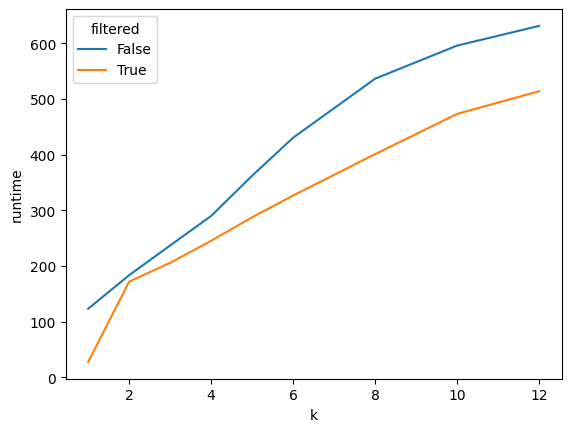

In [8]:
fildf = sp_rdf.reset_index().groupby(['k', 'filtered'])['runtime', 'test_roc_auc', 'test_pr_auc', 'n_cuts'].mean().reset_index()
sns.lineplot(fildf, x='k', y='runtime', hue='filtered')

<AxesSubplot: xlabel='k', ylabel='n_cuts'>

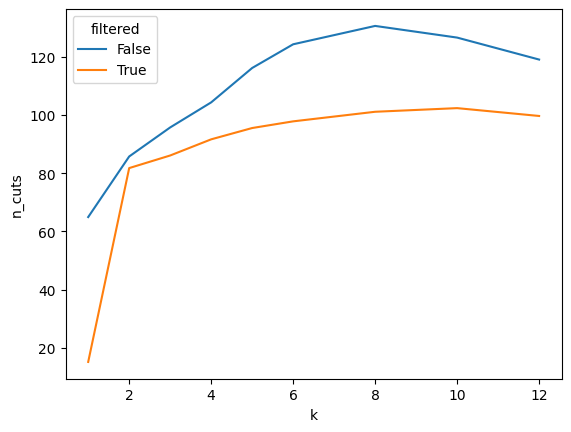

In [9]:
sns.lineplot(fildf, x='k', y='n_cuts', hue='filtered')

<AxesSubplot: xlabel='k', ylabel='test_roc_auc'>

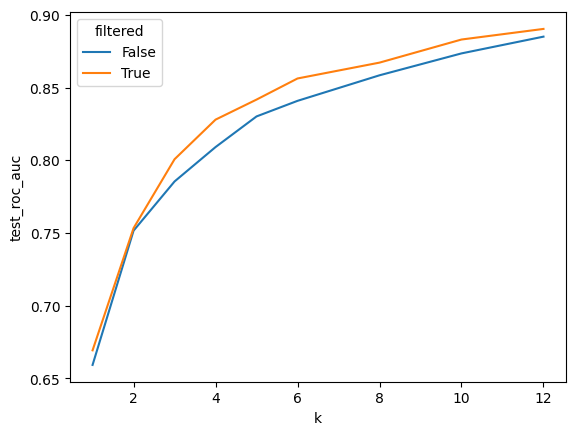

In [10]:
sns.lineplot(fildf, x='k', y='test_roc_auc', hue='filtered')

<AxesSubplot: xlabel='k', ylabel='test_pr_auc'>

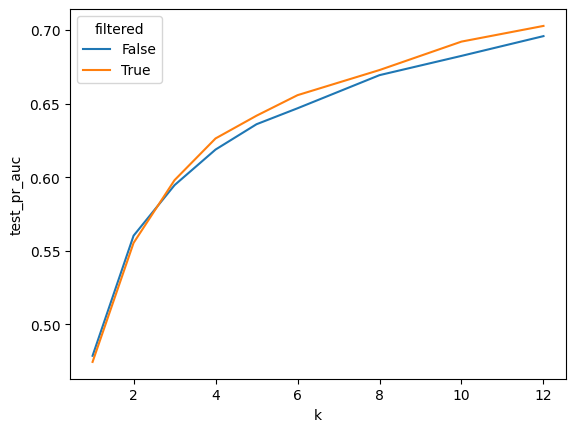

In [11]:
sns.lineplot(fildf, x='k', y='test_pr_auc', hue='filtered')

<AxesSubplot: xlabel='k', ylabel='test_pr_auc'>

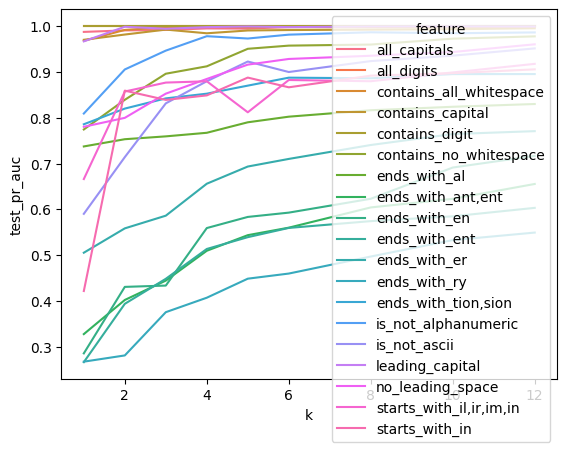

In [22]:
pr_aucs = sp_rdf.groupby(['feature', 'k']).test_pr_auc.max().reset_index()
sns.lineplot(pr_aucs, x='k', y='test_pr_auc', hue='feature')

<AxesSubplot: xlabel='k', ylabel='test_roc_auc'>

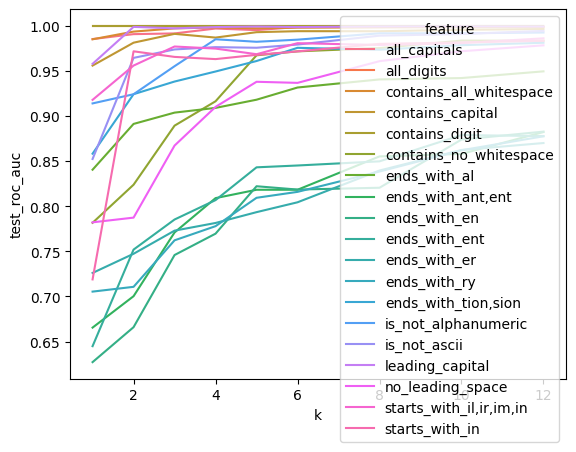

In [23]:
pr_aucs = sp_rdf.groupby(['feature', 'k']).test_roc_auc.max().reset_index()
sns.lineplot(pr_aucs, x='k', y='test_roc_auc', hue='feature')

In [10]:
results.keys()

dict_keys(['contains_digit', 'ends_with_ant,ent', 'starts_with_in', 'ends_with_en', 'ends_with_ry', 'contains_no_whitespace', 'all_digits', 'no_leading_space', 'contains_all_whitespace', 'all_capitals', 'is_not_ascii', 'leading_capital', 'ends_with_ent', 'is_not_alphanumeric', 'ends_with_tion,sion', 'starts_with_il,ir,im,in', 'ends_with_er', 'ends_with_al', 'contains_capital'])

In [166]:
import copy


r_datasets = results.keys()
r_layers = results[list(r_datasets)[1]].keys()

rdfs = {}
heuristic_results = []
for d in r_datasets:
    for l in r_layers:
        try:
            rdf = pd.DataFrame(results[d][l]['sparse_classifier_results']).T
        except:
            continue
        rdfs[(d, l)] = rdf
        ld_result_copy = copy.deepcopy(results[d][l])
        del ld_result_copy['sparse_classifier_results']
        ld_result_copy['layer'] = l
        ld_result_copy['feature'] = d
        heuristic_results.append(ld_result_copy)

In [167]:
results[list(r_datasets)[1]].keys()

dict_keys([8, 2, 6, 1, 5, 11, 0, 4, 10, 3, 9, 7])

In [168]:
sp_rdf = pd.concat(rdfs).sort_index().rename_axis(index=['feature', 'layer', 'k'])
sp_rdf = sp_rdf[sp_rdf.test_roc_auc != 'error']

ValueError: No objects to concatenate

In [103]:
h_rdf = pd.DataFrame(heuristic_results).set_index(['feature', 'layer']).sort_index().reset_index()

In [104]:
h_rdf.head()


feature  layer                                        f_statistic  \
0  is_adj      0  [18.033302, 31.869522, 12.600616, 73.308975, 1...   
1  is_adj      1  [12.48863, 0.6885815, 164.74228, 64.303795, 25...   
2  is_adj      2  [215.79231, 200.14275, 0.76108706, 40.988846, ...   
3  is_adj      3  [5.9065256, 18.597498, 253.2814, 8.078557, 4.8...   
4  is_adj      4  [23.559576, 0.8029636, 32.17323, 31.253592, 9....   

                                           f_p_value  \
0  [2.1809525e-05, 1.6721383e-08, 0.0003865411, 1...   
1  [0.00041039856, 0.4066576, 1.4861951e-37, 1.12...   
2  [0.0, 3e-45, 0.38299945, 1.566474e-10, 0.03719...   
3  [0.015093994, 1.622376e-05, 0.0, 0.0044839326,...   
4  [1.2205664e-06, 0.37022, 1.43050345e-08, 2.295...   

                                         mutual_info  \
0  [0.003231895867185086, 0.017050632793887743, 0...   
1  [0.0, 0.011171731848700572, 0.0075908817477226...   
2  [0.00934541664122901, 0.011079220386153166, 0....   
3  [0.00672191569896774, 0.0023762780110232473, 0...   
4  [0.0035083821395514025, 0.0031175520239421495,...   

                                            lr_coefs       lr_bias  \
0  [[-0.021824718, 0.0, 0.23923542, -0.0001715762...  [-1.1817216]   
1  [[-0.58008885, 0.0, -0.45910838, -0.5290438, 0...  [-1.5404834]   
2  [[-0.123106025, 0.43949994, -0.015029346, 0.13...  [-0.5283388]   
3  [[0.0, -0.17237337, -0.20856376, -0.33346677, ...   [-3.061939]   
4  [[1.1856147, -0.6445684, 0.0, 0.0, -0.5265601,...   [-3.925146]   

   lr_test_acc  lr_test_balanced_acc  lr_test_precision  lr_test_recall  \
0     0.964010              0.910385           0.675676        0.848828   
1     0.967031              0.919151           0.696871        0.864188   
2     0.960885              0.931297           0.640138        0.897332   
3     0.967187              0.918481           0.698756        0.862571   
4     0.967656              0.914592           0.705882        0.853678   

   lr_test_average_precision  lr_test_roc_auc  \
0                   0.583272         0.964961   
1                   0.610977         0.969361   
2                   0.581031         0.981525   
3                   0.611580         0.977622   
4                   0.612023         0.976107   

                                         lr_test_fpr  \
0  [0.0, 0.0, 0.0, 5.566998830930246e-05, 5.56699...   
1  [0.0, 0.0, 0.0, 5.566998830930246e-05, 5.56699...   
2  [0.0, 5.566998830930246e-05, 5.566998830930246...   
3  [0.0, 0.0, 0.0, 5.566998830930246e-05, 5.56699...   
4  [0.0, 0.0, 0.0, 5.566998830930246e-05, 5.56699...   

                                         lr_test_tpr  
0  [0.0, 0.0008084074373484236, 0.005658852061438...  
1  [0.0, 0.0008084074373484236, 0.101050929668552...  
2  [0.0, 0.0, 0.10509296685529507, 0.105092966855...  
3  [0.0, 0.0008084074373484236, 0.053354890864995...  
4  [0.0, 0.0008084074373484236, 0.005658852061438...

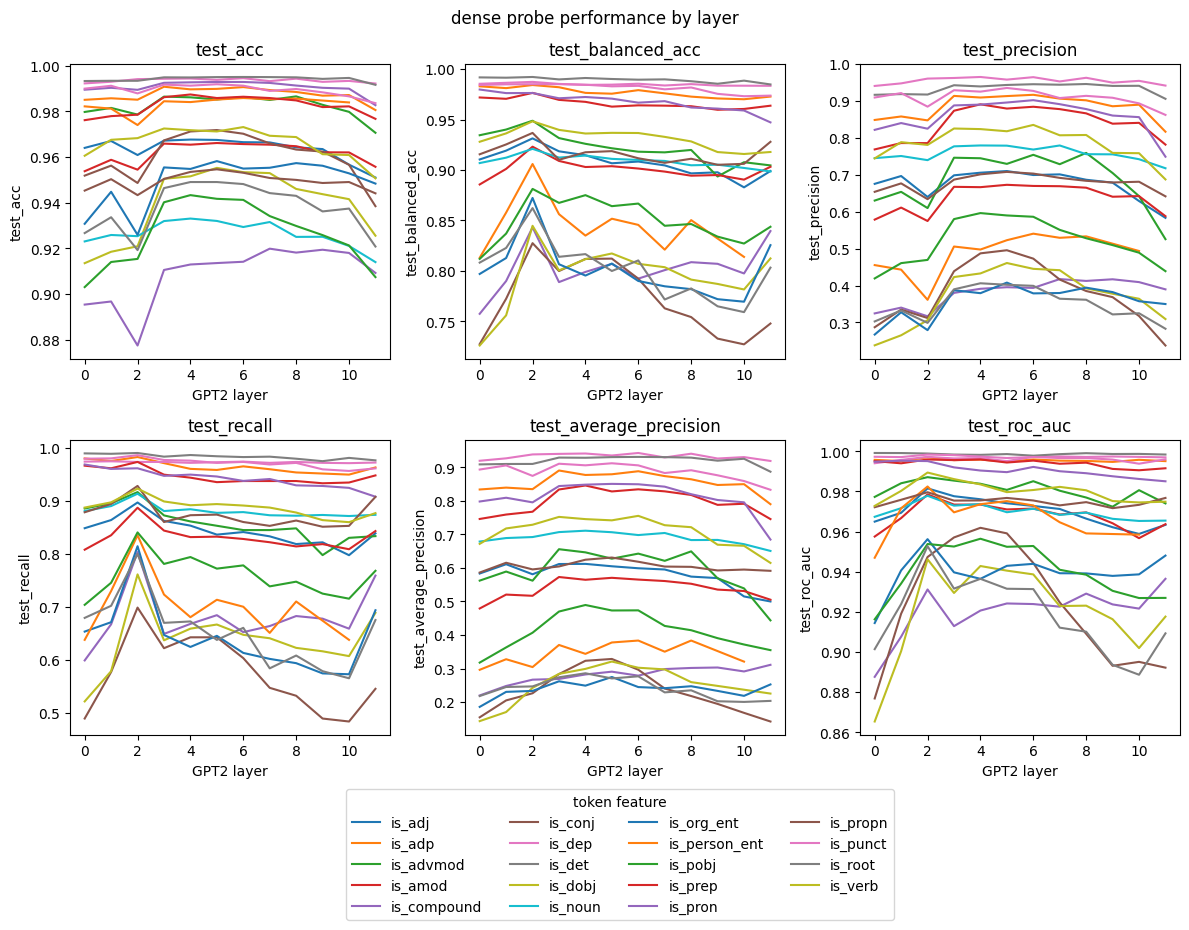

In [105]:
metrics = ['lr_test_acc', 'lr_test_balanced_acc', 'lr_test_precision', 'lr_test_recall', 'lr_test_average_precision', 'lr_test_roc_auc']

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for ix, m in enumerate(metrics):
    ax = axs[ix//3, ix%3]
    layers = sorted(h_rdf.layer.unique())
    features = sorted(h_rdf.feature.unique())
    for f in features:
        f_rdf = h_rdf.query('feature == @f')
        ax.plot(f_rdf.layer, f_rdf[m].values, label=f)
    ax.set_xlabel('GPT2 layer')
    ax.set_ylabel(m[3:])
    ax.set_title(m[3:])
plt.suptitle('dense probe performance by layer')
plt.tight_layout()
plt.legend(title='token feature', loc='lower center', bbox_to_anchor=(-0.75, -0.65), ncols=4)


In [106]:
h_rdf.groupby('feature').mean().lr_test_roc_auc.sort_values()

/var/folders/8f/qz9dtbzx2s77drzzcdl8xztm0000gn/T/ipykernel_21141/1612934350.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  h_rdf.groupby('feature').mean().lr_test_roc_auc.sort_values()


feature
is_root          0.918547
is_compound      0.920108
is_dobj          0.920428
is_conj          0.923307
is_org_ent       0.939771
is_pobj          0.940178
is_person_ent    0.967464
is_amod          0.967896
is_adj           0.969877
is_noun          0.969948
is_propn         0.975025
is_verb          0.979998
is_advmod        0.980664
is_pron          0.990624
is_prep          0.993991
is_adp           0.995524
is_dep           0.996556
is_punct         0.996752
is_det           0.998640
Name: lr_test_roc_auc, dtype: float64

In [113]:
h_rdf.groupby('feature').lr_test_roc_auc.max().sort_values()

feature
is_compound      0.936456
is_dobj          0.946179
is_root          0.952718
is_org_ent       0.956219
is_pobj          0.956434
is_conj          0.961878
is_noun          0.977836
is_amod          0.978516
is_propn         0.979606
is_adj           0.981525
is_person_ent    0.982469
is_advmod        0.987118
is_verb          0.989418
is_pron          0.995315
is_prep          0.995966
is_adp           0.997022
is_dep           0.997440
is_punct         0.998370
is_det           0.999169
Name: lr_test_roc_auc, dtype: float64

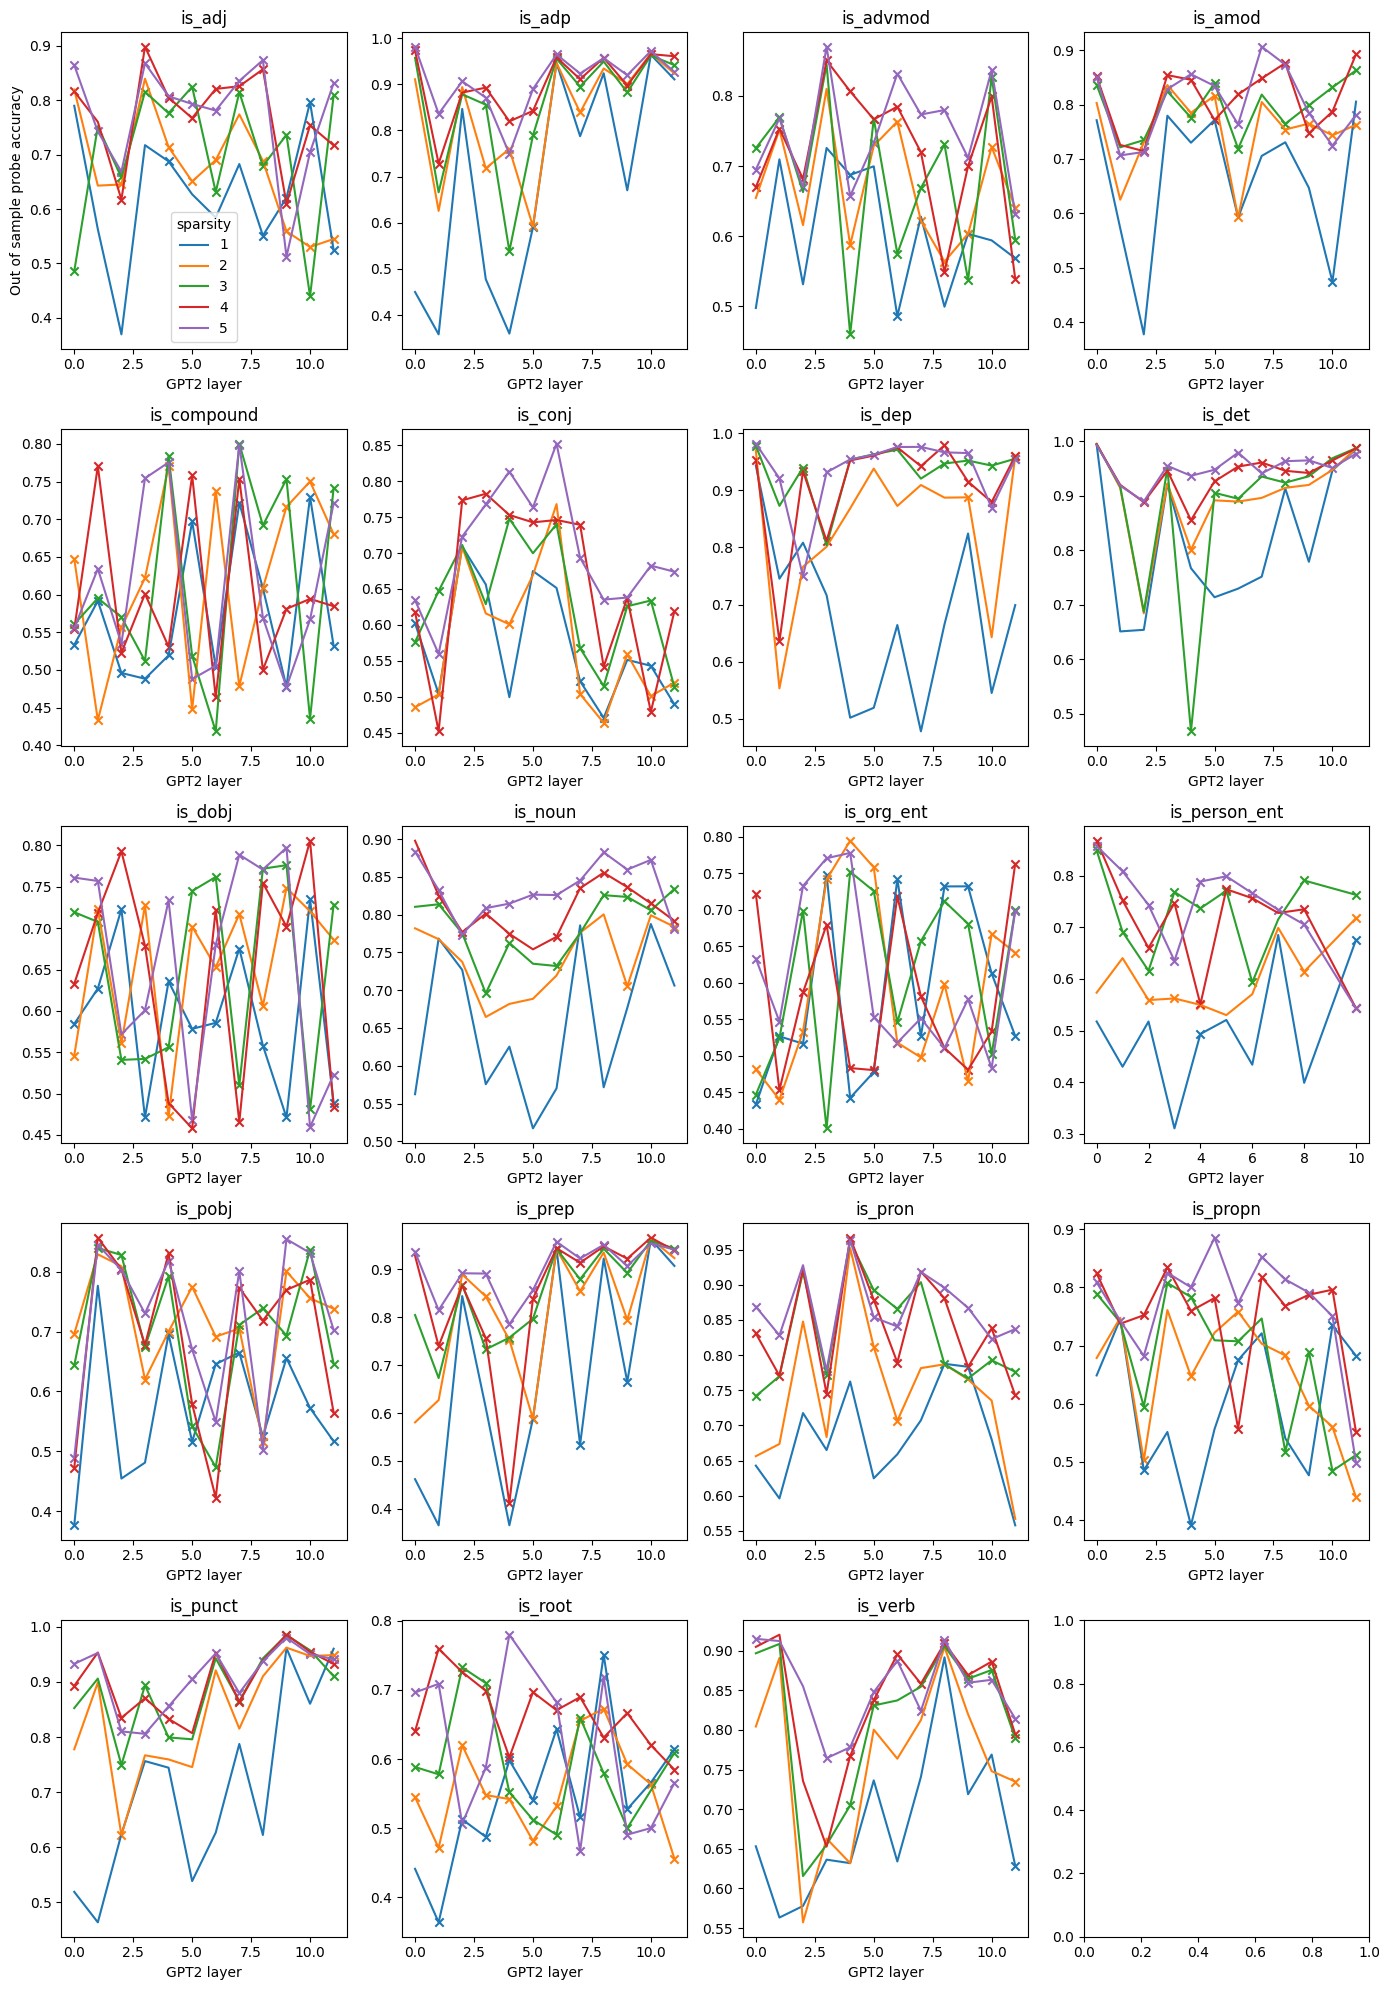

In [120]:
import math

features = sorted(sp_rdf.index.get_level_values(0).unique())
layers = sorted(sp_rdf.index.get_level_values(1).unique())
ks = sorted(sp_rdf.index.get_level_values(2).unique())
fig, axs = plt.subplots(math.ceil(len(features) / 4), 4, figsize=(14, math.ceil(len(features) / 4) * 4))

for ix, f in enumerate(features):
    ax = axs[ix//4, ix%4]
    ax.set_title(f)
    ax.set_xlabel('GPT2 layer')

    for k in ks:
        layer_sp_df = sp_rdf.loc[f, :, k]
        layer = layer_sp_df.index.values
        acc = layer_sp_df.test_roc_auc.values
        try:
            ax.plot(layer, acc, label=str(k))
            finished = layer_sp_df.model_status.values == 2
            #ax.scatter(layer[finished], acc[finished], marker='o')
            ax.scatter(layer[~finished], acc[~finished], marker='x')
        except ValueError:
            print(acc)
    if ix == 0:
        ax.set_ylabel('Out of sample probe accuracy')
        ax.legend(title='sparsity')
plt.tight_layout()

In [128]:
k_aucs = sp_rdf.groupby(['feature', 'k']).test_roc_auc.max().unstack()#.reset_index()

In [140]:
k_aucs =sp_rdf.groupby(['feature', 'k']).test_roc_auc.max().reset_index()

Text(0.5, 1.0, 'Best AUC by sparsity and feature')

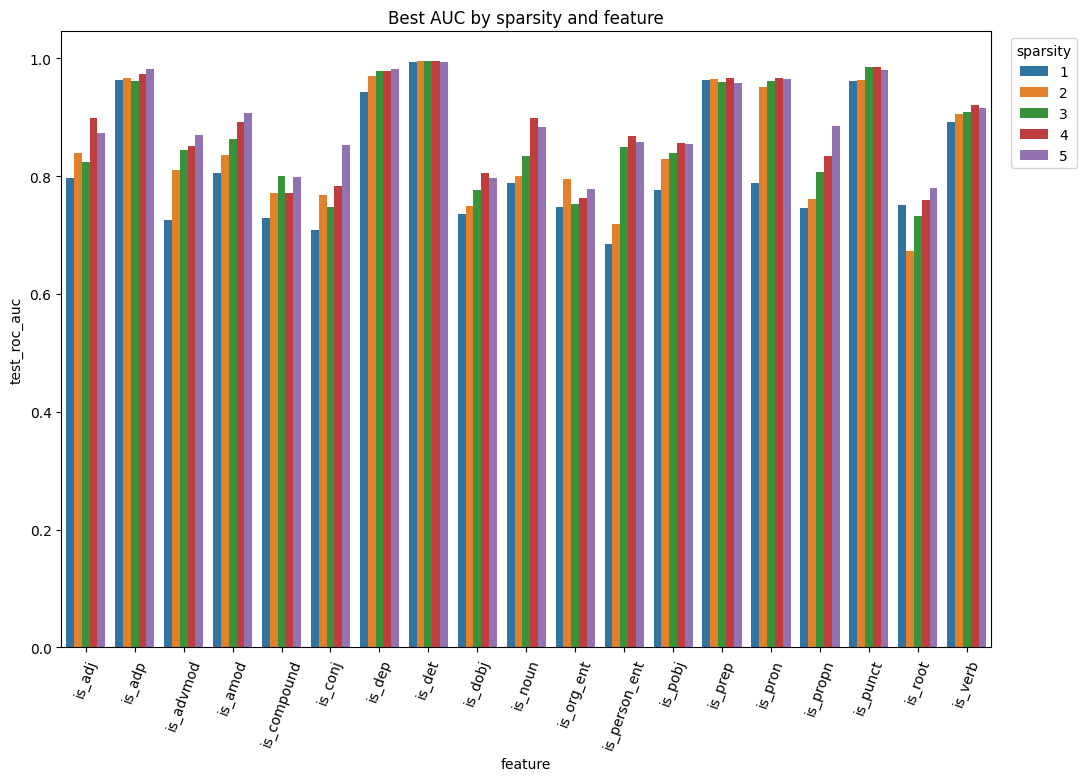

In [157]:
import seaborn as sns

plt.figure(figsize=(12,8))
g = sns.barplot(data=k_aucs, x='feature', y='test_roc_auc', hue='k')
plt.xticks(rotation=70);
plt.legend(title='sparsity', loc='upper right', bbox_to_anchor=(1.1, 1))
plt.title('Best AUC by sparsity and feature')

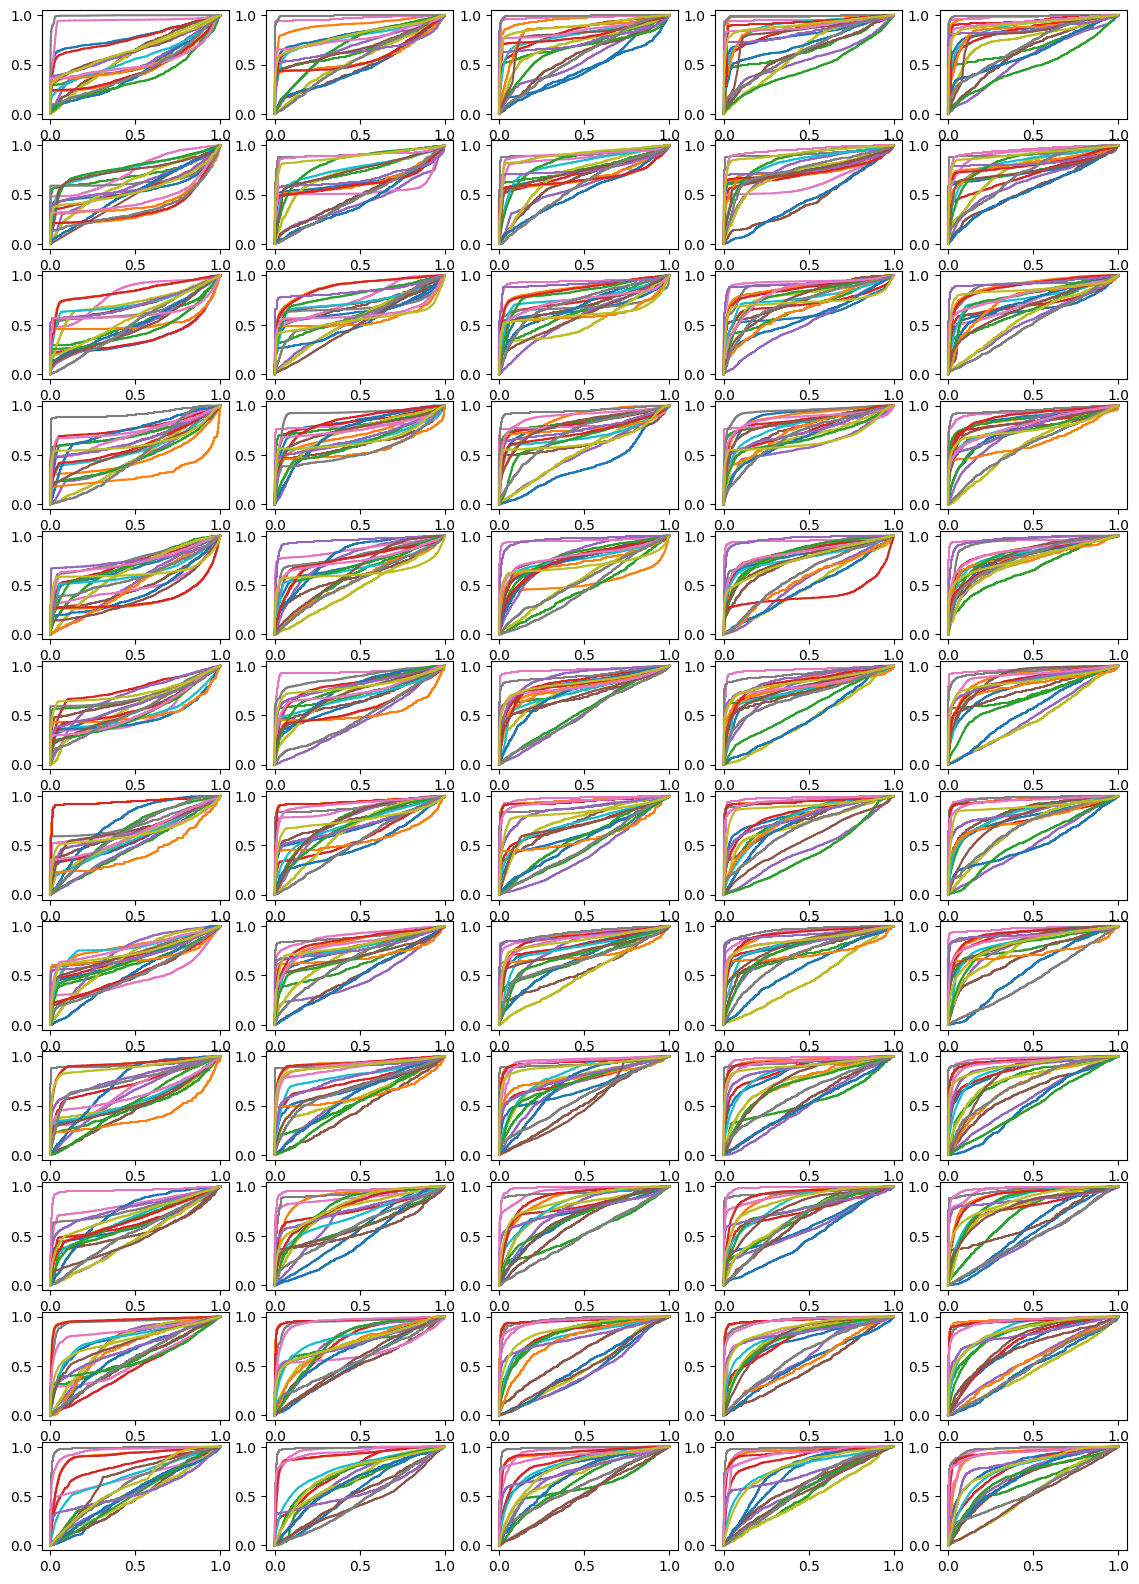

In [108]:
features = sorted(sp_rdf.index.get_level_values(0).unique())
layers = sorted(sp_rdf.index.get_level_values(1).unique())
ks = sorted(sp_rdf.index.get_level_values(2).unique())
fig, axs = plt.subplots(len(layers), len(ks), figsize=(14, 20))
for l in layers:
    for k in ks:
        ax = axs[l, k-1]
        for f in features:
            try:
                fpr = sp_rdf.loc[f, l, k]['test_fpr']
                tpr = sp_rdf.loc[f, l, k]['test_tpr']
                ax.plot(fpr, tpr, label=f)
            except (ValueError, KeyError):
                ax.plot([], [], label=f)


In [89]:
(sp_rdf.model_status == 2).mean()

0.31894736842105265

In [94]:
layers

[1, 2, 3, 4, 5]